### Python environment information

This notebook must be run in an environment where the following packages are installed:

xarray, dask, numpy

matplotlib and cartopy are optional if you want to uncomment the plotting portions

It is suggested that the user builds a conda environment with these packages on HPC Orion using the system module miniconda. 

The user also needs to create a jupyter kernel from this conda environment before launching the notebook.

### How to launch this notebook

Launch on an orion node as usual. Unless the region you are subsetting to is very large, you won't need many tasks. 4-10 should be enough.

# Set Up

### packages

In [1]:
import numpy as np
import dask.array as da
import xarray as xr
import os

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

ERROR 1: PROJ: proj_create_from_database: Open of /work/hpc/users/kerrie/envs/dataprep/share/proj failed


### files, directories, and other constants

In [2]:
# directories
fao_basedir='/change/this/to/the/shared/datasets/directory/' # the group's shared datasets dir
global_npy_dir='pyaez/inputs/global/daily365_npy/' # dir of the global pyaez files
subset_dir=fao_basedir+'pyaez/inputs/subsets/'     # dir for writing country subsets

maskfile=fao_basedir+'gaez_v5/land/ALOSmask5m_fill.rst'  # the mask file from Gunther
elevfile=fao_basedir+'gaez_v5/land/ALOSdem5m_fill.rst'   # the elevation file from Gunther
soilfile=fao_basedir+'pyaez/inputs/global/static_tif/soil_terrain_lulc_global_08333.tif'  # the soil file from Swun

# variable names and pyaez units
var_info={'Precip':'Precip (mm/day)',
             'Srad':'Srad (W/m2)',
             'Tmax-2m':'Tmax-2m (C)',
             'Tmin-2m':'Tmin-2m (C)',
             'Rhum':'Rhum (fraction)',
             'Wind-2m':'Wind-2m (m/s)'}

# lat/lon dimension names in the tiff files
ydimname='y' 
xdimname='x'

### user to define bounding box and give it a unique name

[online tool to get a quick rectangular bounding box](https://boundingbox.klokantech.com/)

select csv in the drop down menu at the bottom left of the page to get the box limits and paste them below to xmin,ymin,xmax,ymax below

Note: you might want to check if the HPC Orion directory subset_dir/output_name already exists or you will be overwriting files

In [3]:
xmin,ymin,xmax,ymax = 30.09,-27.42,41.19,-10.19 
output_name='mozambique'

# xmin,ymin,xmax,ymax = 60.67,23.43,80.62,37.19
# output_name='pakistan'

# xmin,ymin,xmax,ymax =7.32,29.98,11.93,37.47
# output_name='tunisia'


### user to define years to process

In [4]:
years=np.arange(2020,2021) # the end year is not inclusive

# Begin Main Code

In [5]:
### get the data grid from the mask file

# open the maskfile
mask=xr.open_dataset(maskfile,engine='rasterio').squeeze().band_data

# clean up some metadata for consistency with the data processing script
mask[xdimname]=mask[xdimname].astype(np.float32)
mask[ydimname]=mask[ydimname].astype(np.float32)

mask=xr.where(mask>0,1,0)
# mask

In [6]:
# get the indices of the nearest lats and lons to the bounding box
ilatN = list(mask.y).index(mask.y.sel(y=ymax, method='nearest'))
ilatS = list(mask.y).index(mask.y.sel(y=ymin, method='nearest'))
ilonW = list(mask.x).index(mask.x.sel(x=xmin, method='nearest'))
ilonE = list(mask.x).index(mask.x.sel(x=xmax, method='nearest'))
ilatN,ilatS,ilonW,ilonE

(1202, 1409, 2521, 2654)

In [7]:
# subset the mask
mask_subset=mask[ilatN:ilatS,ilonW:ilonE]

# look at the new shape
mask_subset.shape

(207, 133)

writing tiff files to /work/hpc/datasets/un_fao/pyaez/inputs/subsets/mozambique/static_tif/


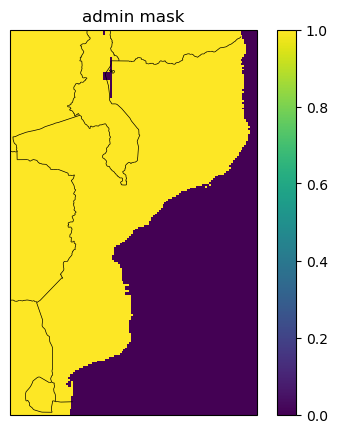

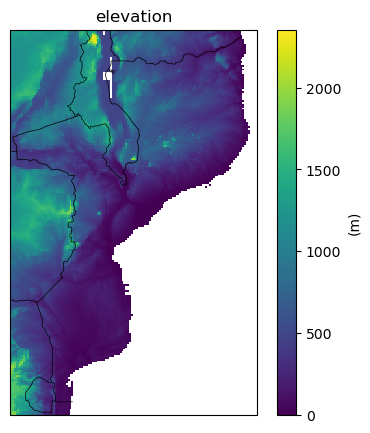

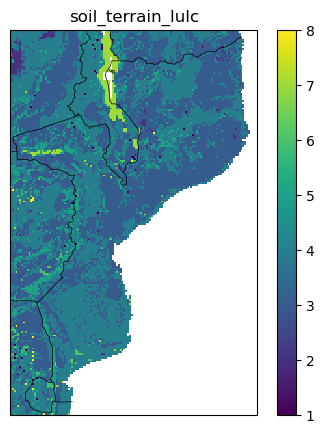

writing npy file to /work/hpc/datasets/un_fao/pyaez/inputs/subsets/mozambique/daily365_npy/2020/Precip


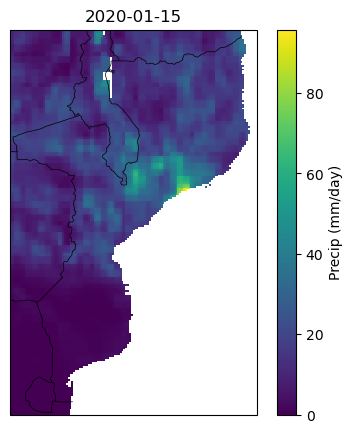

writing npy file to /work/hpc/datasets/un_fao/pyaez/inputs/subsets/mozambique/daily365_npy/2020/Srad


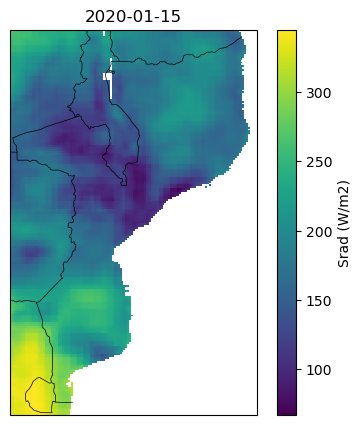

writing npy file to /work/hpc/datasets/un_fao/pyaez/inputs/subsets/mozambique/daily365_npy/2020/Tmax-2m


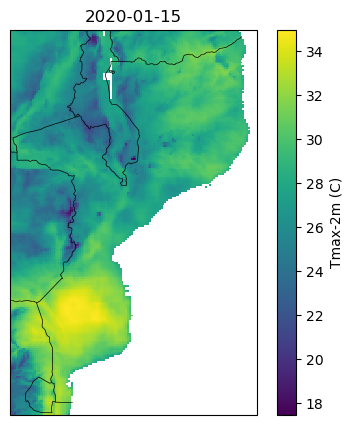

writing npy file to /work/hpc/datasets/un_fao/pyaez/inputs/subsets/mozambique/daily365_npy/2020/Tmin-2m


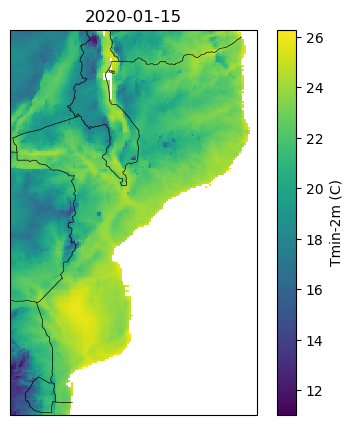

writing npy file to /work/hpc/datasets/un_fao/pyaez/inputs/subsets/mozambique/daily365_npy/2020/Rhum


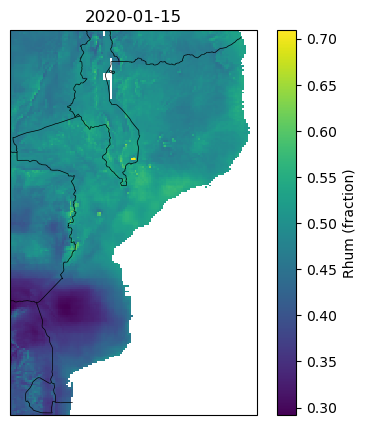

writing npy file to /work/hpc/datasets/un_fao/pyaez/inputs/subsets/mozambique/daily365_npy/2020/Wind-2m


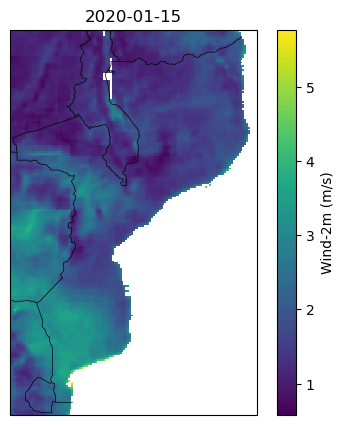

In [8]:
# subset the data variables

for iy,yyyy in enumerate(years):
    for var in var_info.keys():
        # lazy load global npy stack and subset
        var_subset=da.from_npy_stack(fao_basedir+global_npy_dir+str(yyyy)+'/'+var+'/')[ilatN:ilatS,ilonW:ilonE,:]    

        # check that dims of subsetted mask and variable match
        # if these produce an error, then you need to fix something
        assert var_subset.shape[0]==mask_subset.shape[0],\
            f"latitude dim does not match! \
            mask subset to ny {mask_subset.shape[0]}, \
            {var} subset to ny {var_subset.shape[0]}"
        assert var_subset.shape[1]==mask_subset.shape[1],\
            f"longitude dim does not match! \
            mask subset to nx {mask_subset.shape[1]}, \
            {var} subset to nx {var_subset.shape[1]}"

        # create directory for writing npy stacks
        # NOTE!!! If this dir already exists with files in it they could be overwritten
        dirname=subset_dir+output_name+'/daily365_npy/'+str(yyyy)+'/'+var
        isExist = os.path.exists(dirname)
        if not isExist:
            os.makedirs(dirname)     

        # write subsetted variable to npy file, no chunking
        da.to_npy_stack(dirname,var_subset)

        # now create subsetted tiffs of mask, elev, and soil
        if (var=='Precip') and (iy==0):
            # pick one day to create mask from the data (which is slightly different than the ALOS mask)
            pr_mask=xr.where(np.isfinite(var_subset[:,:,14].compute()),1,0)            
            # adjust the mask to match where data is present
            mask_subset=xr.where(pr_mask,mask_subset,0)

            # read and subset elevation, apply mask, adjust lat/lon precision for consistency
            elev_subset=xr.open_dataset(elevfile,engine='rasterio').squeeze().band_data[ilatN:ilatS,ilonW:ilonE]
            elev_subset=xr.where(pr_mask,elev_subset,np.float32(np.nan))
            elev_subset[xdimname]=elev_subset[xdimname].astype(np.float32)
            elev_subset[ydimname]=elev_subset[ydimname].astype(np.float32)        

            # read and subset soil, apply mask, adjust lat/lon precision for consistency
            soil_subset=xr.open_dataset(soilfile,engine='rasterio').squeeze().band_data[ilatN:ilatS,ilonW:ilonE]
            soil_subset=xr.where(pr_mask,soil_subset,np.float32(np.nan))
            soil_subset[xdimname]=soil_subset[xdimname].astype(np.float32)
            soil_subset[ydimname]=soil_subset[ydimname].astype(np.float32)  

            # error checking
            assert elev_subset.shape[0]==mask_subset.shape[0],\
                f"latitude dim does not match! \
                mask subset to ny {mask_subset.shape[0]}, \
                elev subset to ny {elev_subset.shape[0]}"
            assert elev_subset.shape[1]==mask_subset.shape[1],\
                f"longitude dim does not match! \
                mask subset to nx {mask_subset.shape[1]}, \
                elev subset to nx {elev_subset.shape[1]}"        
            assert soil_subset.shape[0]==mask_subset.shape[0],\
                f"latitude dim does not match! \
                mask subset to ny {mask_subset.shape[0]}, \
                soil subset to ny {soil_subset.shape[0]}"
            assert soil_subset.shape[1]==mask_subset.shape[1],\
                f"longitude dim does not match! \
                mask subset to nx {mask_subset.shape[1]}, \
                soil subset to nx {soil_subset.shape[1]}"           

            # writing tiff files
            # first make sure dir exists
            dirstatic=subset_dir+output_name+'/static_tif/'
            isExist = os.path.exists(dirstatic)
            if not isExist:
                os.makedirs(dirstatic) 
            # write files
            print('writing tiff files to', dirstatic)
            mask_subset.rio.to_raster(dirstatic+'admin_mask_'+output_name+'.tif')
            elev_subset.rio.to_raster(dirstatic+'elev_'+output_name+'.tif')
            soil_subset.rio.to_raster(dirstatic+'soil_terrain_lulc_'+output_name+'.tif')

            # plot tiff variables
            fig=plt.figure(figsize=(5,5))
            ax=fig.add_subplot(111,projection=ccrs.PlateCarree())  # projection comes from cartopy package
            ax.add_feature(cfeature.BORDERS,linewidth=0.5)  # cartopy country borders
            plt.pcolormesh(mask_subset.x.data,mask_subset.y.data,mask_subset)
            plt.title('admin mask')
            plt.colorbar()
            plt.show()

            fig=plt.figure(figsize=(5,5))
            ax=fig.add_subplot(111,projection=ccrs.PlateCarree())  # projection comes from cartopy package
            ax.add_feature(cfeature.BORDERS,linewidth=0.5)  # cartopy country borders
            plt.pcolormesh(mask_subset.x.data,mask_subset.y.data,elev_subset)
            plt.title('elevation')
            plt.colorbar(label='(m)')
            plt.show() 

            fig=plt.figure(figsize=(5,5))
            ax=fig.add_subplot(111,projection=ccrs.PlateCarree())  # projection comes from cartopy package
            ax.add_feature(cfeature.BORDERS,linewidth=0.5)  # cartopy country borders
            plt.pcolormesh(mask_subset.x.data,mask_subset.y.data,soil_subset)
            plt.title('soil_terrain_lulc')
            plt.colorbar()
            plt.show() 

        print('writing npy file to',dirname)

        # plot data variables
        fig=plt.figure(figsize=(5,5))
        ax=fig.add_subplot(111,projection=ccrs.PlateCarree())  # projection comes from cartopy package
        ax.add_feature(cfeature.BORDERS,linewidth=0.5)  # cartopy country borders
        plt.pcolormesh(mask_subset.x.data,mask_subset.y.data,var_subset[:,:,14])
        plt.title('2020-01-15')
        plt.colorbar(label=var_info[var])
        plt.show() 